In [1]:
from transformers import pipeline
import torch
import os

import seaborn as sns
import matplotlib.pyplot as plt
from src.metrics import compute_score
from src.generate import model_evaluation
from scipy.stats import pearsonr

OUTPUT_FOLDER = "output/samples/en/phase_2/model/base_prompt/two_shot"
if not os.path.exists(OUTPUT_FOLDER):
    os.makedirs(OUTPUT_FOLDER)
    
# model_id = "meta-llama/Llama-3.2-3B-Instruct"
model_id = "/gpfs/projects/bsc14/abecerr1/hub/models--meta-llama--Llama-3.2-3B-Instruct/snapshots/0cb88a4f764b7a12671c53f0838cd831a0843b95"
pipe = pipeline(
    "text-generation",
    model=model_id,
    torch_dtype=torch.bfloat16,
    # device="cuda",
    device_map="auto",
)


/gpfs/projects/bsc14/code/MultiSynDS/.venv/lib64/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading checkpoint shards: 100%|██████████| 2/2 [00:08<00:00,  4.43s/it]
Device set to use cuda:0


In [2]:
# Evaluate phase 1 data
from src.data import files_to_df
import os

data_path = "output/samples/en/phase_2/"
k_shot_filenames = ["33857916", "31378248"]
eval_filenames = ['34530632', '32997782', '30785587', '26989133', '29617510', '30072860', '30930460', '31049155', '31056078', '31204375', '31486515', '31512669', '31557359']
human_eval_file="output/samples/en/phase_2/human_eval.csv"
base_filenames_path="output/samples/en/phase_2"

sample_df_gen = files_to_df(os.path.join(data_path, "generated"))
sample_df_gen["filenameid"] = sample_df_gen["filenameid"].str.replace("_transformed_step1", "")

sample_df_orig = files_to_df(os.path.join(data_path, "original"))
sample_df = sample_df_orig.merge(sample_df_gen, on="filenameid", suffixes=("_orig", "_gen"))

sample_df = sample_df[sample_df["filenameid"].isin(eval_filenames)]
sample_df

,filenameid,text_orig,text_gen
2,29617510,An 81-year-old male patient was admitted due t...,**Discharge Summary**\n\n**Patient Information...
4,31204375,A 92-year-old man was admitted to our hospital...,**Discharge Summary**\n\n**Patient Information...
7,31056078,"Initial presentation\nA 55-year-old, Caucasian...",**Discharge Summary**\n\n**Patient Information...
8,31486515,A 57-year-old Caucasian man was admitted to th...,**Discharge Summary**\n\n**Patient Information...
12,31512669,A 25-year-old male who presented with acute on...,**Discharge Summary**\n\n**Patient Information...
13,32997782,"In March 2017, a 67-year-old man with hyperten...",**Discharge Summary**\n\n**Patient Information...
14,31557359,"A 61‐year‐old man, diabetic and hypertensive, ...",**Discharge Summary**\n\n**Patient Information...
15,26989133,A previously fit and healthy 75-year-old Chine...,**Discharge Summary**\n\n**Patient Information...
16,31049155,A 30-year-old woman with a history of neonatal...,**Discharge Summary**\n\n**Patient Information...
21,34530632,"A 70-year-old man (170 cm, 48 kg, American Soc...",**Discharge Summary**\n\n**Patient Information...


In [3]:
import pandas as pd
from tqdm import tqdm
tqdm.pandas()

filenames = []
d_gen = sample_df.progress_apply(lambda x: model_evaluation(pipe, x["text_orig"], x["text_gen"], k_shot_filenames, "hf", human_eval_file=human_eval_file, base_filenames_path=base_filenames_path),
                                    axis=1)


100%|██████████| 12/12 [00:42<00:00,  3.53s/it]


In [4]:
d_gen.iloc[0]

{'Content Relevance': 5,
 'Information Completeness': 5,
 'Clarity and Structure': 5,
 'Content Accuracy': 5,
 'Hallucinations': 1,
 'Impact of Hallucinations': 1,
 'Relevance to Practice': 5,
 'Overall Quality': 5,
 'Positive highlights of generation process': 'Highly accurate in the diagnosis. Excellent overall performance.',
 'Negative highlights of generation process': 'Omitted information: ECG Holter and EKG after CV (both are important in FA clinical cases).',
 'Other comments on Generated/Original data sources': 'Unknown'}

In [5]:
df_metrics = pd.DataFrame(d_gen.tolist(), index=sample_df.index)
df_model_eval = pd.concat([sample_df, df_metrics], axis=1)
df_model_eval

,filenameid,text_orig,text_gen,Content Relevance,Information Completeness,Clarity and Structure,Content Accuracy,Hallucinations,Impact of Hallucinations,Relevance to Practice,Overall Quality,Positive highlights of generation process,Negative highlights of generation process,Other comments on Generated/Original data sources
2,29617510,An 81-year-old male patient was admitted due t...,**Discharge Summary**\n\n**Patient Information...,5,5,5,5,1,1,5,5,Highly accurate in the diagnosis. Excellent ov...,Omitted information: ECG Holter and EKG after ...,Unknown
4,31204375,A 92-year-old man was admitted to our hospital...,**Discharge Summary**\n\n**Patient Information...,5,5,5,5,1,1,5,5,Highly accurate in the diagnosis. Excellent ov...,Omitted information: ECG Holter and EKG after ...,Unknown
7,31056078,"Initial presentation\nA 55-year-old, Caucasian...",**Discharge Summary**\n\n**Patient Information...,5,5,5,5,1,1,5,4,Highly accurate in the diagnosis. Excellent ov...,Omitted information: ECG Holter and EKG after ...,Unknown
8,31486515,A 57-year-old Caucasian man was admitted to th...,**Discharge Summary**\n\n**Patient Information...,5,5,5,5,1,1,5,5,Highly accurate in the diagnosis. Excellent ov...,Omitted information: ECG Holter and EKG after ...,Unknown
12,31512669,A 25-year-old male who presented with acute on...,**Discharge Summary**\n\n**Patient Information...,5,5,5,5,1,1,5,5,Highly accurate in the diagnosis. Excellent ov...,Omitted information: ECG Holter and EKG after ...,Unknown
13,32997782,"In March 2017, a 67-year-old man with hyperten...",**Discharge Summary**\n\n**Patient Information...,5,5,5,5,1,1,5,4,Excellent overall performance,Omitted information: ECG Holter and EKG after ...,Unknown
14,31557359,"A 61‐year‐old man, diabetic and hypertensive, ...",**Discharge Summary**\n\n**Patient Information...,5,5,5,5,1,1,5,5,Highly accurate in the diagnosis. Excellent ov...,Omitted information: ECG Holter and EKG after ...,Unknown
15,26989133,A previously fit and healthy 75-year-old Chine...,**Discharge Summary**\n\n**Patient Information...,5,5,5,5,1,1,5,5,Highly accurate in the diagnosis. Excellent ov...,Omitted information: ECG Holter and EKG after ...,Unknown
16,31049155,A 30-year-old woman with a history of neonatal...,**Discharge Summary**\n\n**Patient Information...,5,5,5,5,1,1,5,5,Highly accurate in the diagnosis. Excellent ov...,Omitted information: ECG Holter and EKG after ...,Unknown
21,34530632,"A 70-year-old man (170 cm, 48 kg, American Soc...",**Discharge Summary**\n\n**Patient Information...,5,5,5,5,1,1,5,5,Highly accurate in the diagnosis. Excellent ov...,Omitted information: ECG Holter and EKG after ...,Unknown


In [6]:
for index, row in df_model_eval.iterrows():
    print(row["Positive highlights of generation process"])
    print(row["Negative highlights of generation process"])

    print("\n\n")

Highly accurate in the diagnosis. Excellent overall performance.
Omitted information: ECG Holter and EKG after CV (both are important in FA clinical cases).



Highly accurate in the diagnosis. Excellent overall performance.
Omitted information: ECG Holter and EKG after CV (both are important in FA clinical cases).



Highly accurate in the diagnosis. Excellent overall performance.
Omitted information: ECG Holter and EKG after CV (both are important in FA clinical cases).



Highly accurate in the diagnosis. Excellent overall performance.
Omitted information: ECG Holter and EKG after CV (both are important in FA clinical cases).



Highly accurate in the diagnosis. Excellent overall performance.
Omitted information: ECG Holter and EKG after CV (both are important in FA clinical cases).



Excellent overall performance
Omitted information: ECG Holter and EKG after CV (both are important in FA clinical cases)



Highly accurate in the diagnosis. Excellent overall performance.
Omitted inf

In [7]:
df_model_eval.to_csv(os.path.join(OUTPUT_FOLDER, "model_evaluation.csv"), index=False)

# Load Human Evaluation

In [8]:
he_path = "output/samples/en/phase_2/human_eval.csv"
df_human_eval = pd.read_csv(he_path)
df_human_eval = df_human_eval.iloc[:, 2:]
df_human_eval.columns = ["filenameid", 'Content Relevance', 'Information Completeness', 'Clarity and Structure', 'Content Accuracy',\
       'Hallucinations', 'Impact of Hallucinations', 'Relevance to Practice', 'Overall Quality',\
       'Positive highlights of generation process', 'Negative highlights of generation process', 'Other comments on Generated/Original data sources'\
       ]
df_human_eval["filenameid"] = df_human_eval["filenameid"].astype(str) 
df_human_eval = df_human_eval[df_human_eval["filenameid"].isin(eval_filenames)]
df_human_eval

,filenameid,Content Relevance,Information Completeness,Clarity and Structure,Content Accuracy,Hallucinations,Impact of Hallucinations,Relevance to Practice,Overall Quality,Positive highlights of generation process,Negative highlights of generation process,Other comments on Generated/Original data sources
1,34530632,5,4,5,5,1,1,5,4,Very good performance in general.,"Lack of some information e.g., desfibrillator ...",NaN
2,32997782,4,2,5,4,1,1,2,3,Very well structured and explained. Abbrevatio...,"The text has been oversummarized, leaving out ...",NaN
4,30785587,1,1,2,2,1,1,1,2,NaN,Too much information omitted and the text is o...,NaN
5,26989133,5,4,5,5,1,1,5,5,NaN,NaN,NaN
6,29617510,4,4,4,5,1,1,5,4,NaN,"falta información sobre tipo de prótesis, ause...",NaN
7,30072860,4,3,4,3,1,1,3,3,ordena muy bien los resultados de la ecografía.,Faltan los datos hemodinámicos cardiacos y pul...,NaN
8,30930460,4,3,4,3,1,1,3,3,NaN,falta información: mencionar estudio de trombo...,NaN
9,31049155,5,5,5,5,1,1,5,5,NaN,NaN,NaN
10,31056078,5,5,3,5,1,1,3,4,"datos muy completos, estrcutura fiel al docume...",La parte correspondiente a la enfermedad actu...,NaN
11,31204375,4,3,4,4,1,1,4,4,NaN,Se pierde mucha información sobre la explicaci...,NaN


In [9]:
len(df_human_eval)

13

In [10]:
auto_path = "output/samples/en/phase_2/phase_2.csv"
df_auto = pd.read_csv(auto_path).rename(columns={"filename": "filenameid"})
df_auto["filenameid"] = df_auto["filenameid"].astype(str)
df_auto = df_auto.drop(columns=["cluster"])
df_auto = df_auto[df_auto["filenameid"].isin(eval_filenames)]
df_auto.dtypes

filenameid     object
precision     float64
recall        float64
f1            float64
tp              int64
fp              int64
fn              int64
dtype: object

In [11]:
len(df_auto)

12

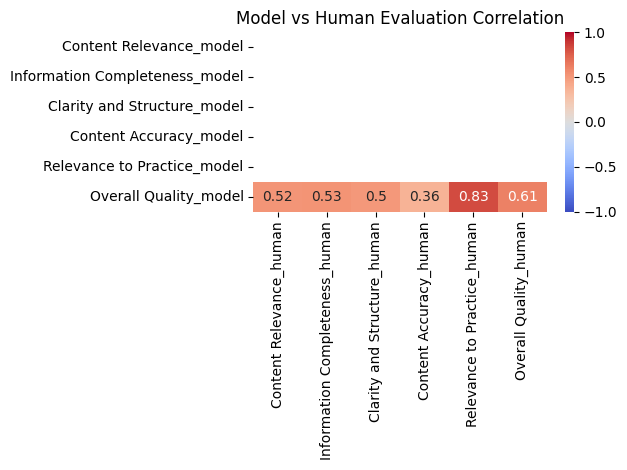

In [12]:
df_total = df_model_eval.merge(df_human_eval, on="filenameid", suffixes=("_model", "_human"))
df_total = df_total.merge(df_auto, on="filenameid")
df_total_num = df_total.select_dtypes(int)

nan_cols = ["Hallucinations_model", "Impact of Hallucinations_model", "Hallucinations_human", "Impact of Hallucinations_human"]

human_cols = [col for col in df_total_num.columns if "human" in col and col not in nan_cols]
model_cols = [col for col in df_total_num.columns if "model" in col and col not in nan_cols]

model_human_corr = df_total_num.corr().loc[model_cols, human_cols]

sns.heatmap(model_human_corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Model vs Human Evaluation Correlation");
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_FOLDER, "model_human_corr.png"), dpi=300)

In [13]:
import numpy as np

df_total.select_dtypes(np.number).to_csv("tmp.csv", index=False)

In [14]:
pearsonr(df_total["Overall Quality_model"], df_total["Overall Quality_human"])

PearsonRResult(statistic=0.6139601294045424, pvalue=0.03369521422928314)

# Auto Evaluation

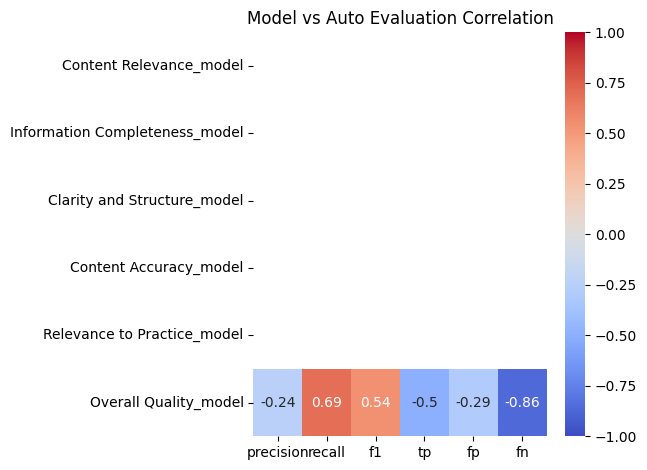

In [15]:
import numpy as np

auto_cols = df_auto.select_dtypes(np.number).columns

model_auto_corr = df_total.select_dtypes(np.number).corr().loc[model_cols, auto_cols]

sns.heatmap(model_auto_corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Model vs Auto Evaluation Correlation");

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_FOLDER, "model_auto_corr.png"), dpi=300)

In [16]:
pearsonr(df_total["f1"], df_total["Overall Quality_model"])

PearsonRResult(statistic=0.5421711239152857, pvalue=0.06859972229892822)

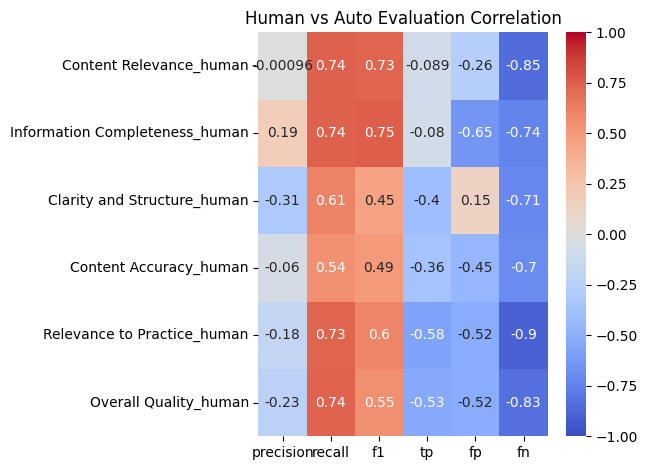

In [17]:
# Now human versus auto

human_auto_corr = df_total.select_dtypes(np.number).corr().loc[human_cols, auto_cols]

sns.heatmap(human_auto_corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Human vs Auto Evaluation Correlation");

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_FOLDER, "human_auto_corr.png"), dpi=300)

In [18]:
from scipy.stats import pearsonr
def compute_score(df_auto, df_human, col_auto, col_human):
    return pearsonr(df_auto[col_auto], df_human[col_human])

compute_score(df_auto, df_total, col_auto="f1", col_human="Overall Quality_human")

PearsonRResult(statistic=0.18449171706386186, pvalue=0.565961251944561)

In [19]:
compute_score(df_auto, df_total, col_auto="f1", col_human="Overall Quality_model")

PearsonRResult(statistic=-0.26813077110679606, pvalue=0.39944507172404986)

In [20]:
df_total

,filenameid,text_orig,text_gen,Content Relevance_model,Information Completeness_model,Clarity and Structure_model,Content Accuracy_model,Hallucinations_model,Impact of Hallucinations_model,Relevance to Practice_model,...,Overall Quality_human,Positive highlights of generation process_human,Negative highlights of generation process_human,Other comments on Generated/Original data sources_human,precision,recall,f1,tp,fp,fn
0,29617510,An 81-year-old male patient was admitted due t...,**Discharge Summary**\n\n**Patient Information...,5,5,5,5,1,1,5,...,4,NaN,"falta información sobre tipo de prótesis, ause...",NaN,0.866667,0.590909,0.702702,13,2,9
1,31204375,A 92-year-old man was admitted to our hospital...,**Discharge Summary**\n\n**Patient Information...,5,5,5,5,1,1,5,...,4,NaN,Se pierde mucha información sobre la explicaci...,NaN,0.333333,0.444444,0.380952,4,8,5
2,31056078,"Initial presentation\nA 55-year-old, Caucasian...",**Discharge Summary**\n\n**Patient Information...,5,5,5,5,1,1,5,...,4,"datos muy completos, estrcutura fiel al docume...",La parte correspondiente a la enfermedad actu...,NaN,0.918919,0.539683,0.680000,34,3,29
3,31486515,A 57-year-old Caucasian man was admitted to th...,**Discharge Summary**\n\n**Patient Information...,5,5,5,5,1,1,5,...,4,NaN,Se debería mencionar el motivo de admisión: an...,NaN,0.827586,0.685714,0.749999,24,5,11
4,31512669,A 25-year-old male who presented with acute on...,**Discharge Summary**\n\n**Patient Information...,5,5,5,5,1,1,5,...,4,Muy bien especificado Chief complaint,Se podría separar la enfermedad actual de los ...,NaN,0.888889,0.960000,0.923076,24,3,1
5,32997782,"In March 2017, a 67-year-old man with hyperten...",**Discharge Summary**\n\n**Patient Information...,5,5,5,5,1,1,5,...,3,Very well structured and explained. Abbrevatio...,"The text has been oversummarized, leaving out ...",NaN,0.666667,0.392857,0.494382,22,11,34
6,31557359,"A 61‐year‐old man, diabetic and hypertensive, ...",**Discharge Summary**\n\n**Patient Information...,5,5,5,5,1,1,5,...,5,NaN,la razón de admisión suele ser algo más genera...,NaN,0.600000,0.666667,0.631578,6,4,3
7,26989133,A previously fit and healthy 75-year-old Chine...,**Discharge Summary**\n\n**Patient Information...,5,5,5,5,1,1,5,...,5,NaN,NaN,NaN,0.750000,0.923077,0.827586,12,4,1
8,31049155,A 30-year-old woman with a history of neonatal...,**Discharge Summary**\n\n**Patient Information...,5,5,5,5,1,1,5,...,5,NaN,NaN,NaN,0.600000,1.000000,0.749999,3,2,0
9,34530632,"A 70-year-old man (170 cm, 48 kg, American Soc...",**Discharge Summary**\n\n**Patient Information...,5,5,5,5,1,1,5,...,4,Very good performance in general.,"Lack of some information e.g., desfibrillator ...",NaN,0.736842,0.736842,0.736842,14,5,5


In [21]:
compute_score(df_total, df_total, col_auto="Overall Quality_human", col_human="Overall Quality_model")

PearsonRResult(statistic=0.6139601294045424, pvalue=0.03369521422928314)

# Metrics

In [22]:
pearson_auto_human = compute_score(df_auto, df_total, col_auto="f1", col_human="Overall Quality_human")
pearson_auto_model = compute_score(df_auto, df_total, col_auto="f1", col_human="Overall Quality_model")
pearson_human_model = compute_score(df_total, df_total, col_auto="Overall Quality_human", col_human="Overall Quality_model")

df_metrics_pearson = pd.DataFrame([pearson_auto_human, pearson_auto_model, pearson_human_model], columns=["pearson", "p-value"], index=["auto_human", "auto_model", "human_model"])
df_metrics_pearson.to_csv(os.path.join(OUTPUT_FOLDER, "pearson_metrics.csv"))

In [23]:
df_metrics_pearson

,pearson,p-value
auto_human,0.184492,0.565961
auto_model,-0.268131,0.399445
human_model,0.613960,0.033695


In [24]:
import numpy as np

In [25]:
df_total


,filenameid,text_orig,text_gen,Content Relevance_model,Information Completeness_model,Clarity and Structure_model,Content Accuracy_model,Hallucinations_model,Impact of Hallucinations_model,Relevance to Practice_model,...,Overall Quality_human,Positive highlights of generation process_human,Negative highlights of generation process_human,Other comments on Generated/Original data sources_human,precision,recall,f1,tp,fp,fn
0,29617510,An 81-year-old male patient was admitted due t...,**Discharge Summary**\n\n**Patient Information...,5,5,5,5,1,1,5,...,4,NaN,"falta información sobre tipo de prótesis, ause...",NaN,0.866667,0.590909,0.702702,13,2,9
1,31204375,A 92-year-old man was admitted to our hospital...,**Discharge Summary**\n\n**Patient Information...,5,5,5,5,1,1,5,...,4,NaN,Se pierde mucha información sobre la explicaci...,NaN,0.333333,0.444444,0.380952,4,8,5
2,31056078,"Initial presentation\nA 55-year-old, Caucasian...",**Discharge Summary**\n\n**Patient Information...,5,5,5,5,1,1,5,...,4,"datos muy completos, estrcutura fiel al docume...",La parte correspondiente a la enfermedad actu...,NaN,0.918919,0.539683,0.680000,34,3,29
3,31486515,A 57-year-old Caucasian man was admitted to th...,**Discharge Summary**\n\n**Patient Information...,5,5,5,5,1,1,5,...,4,NaN,Se debería mencionar el motivo de admisión: an...,NaN,0.827586,0.685714,0.749999,24,5,11
4,31512669,A 25-year-old male who presented with acute on...,**Discharge Summary**\n\n**Patient Information...,5,5,5,5,1,1,5,...,4,Muy bien especificado Chief complaint,Se podría separar la enfermedad actual de los ...,NaN,0.888889,0.960000,0.923076,24,3,1
5,32997782,"In March 2017, a 67-year-old man with hyperten...",**Discharge Summary**\n\n**Patient Information...,5,5,5,5,1,1,5,...,3,Very well structured and explained. Abbrevatio...,"The text has been oversummarized, leaving out ...",NaN,0.666667,0.392857,0.494382,22,11,34
6,31557359,"A 61‐year‐old man, diabetic and hypertensive, ...",**Discharge Summary**\n\n**Patient Information...,5,5,5,5,1,1,5,...,5,NaN,la razón de admisión suele ser algo más genera...,NaN,0.600000,0.666667,0.631578,6,4,3
7,26989133,A previously fit and healthy 75-year-old Chine...,**Discharge Summary**\n\n**Patient Information...,5,5,5,5,1,1,5,...,5,NaN,NaN,NaN,0.750000,0.923077,0.827586,12,4,1
8,31049155,A 30-year-old woman with a history of neonatal...,**Discharge Summary**\n\n**Patient Information...,5,5,5,5,1,1,5,...,5,NaN,NaN,NaN,0.600000,1.000000,0.749999,3,2,0
9,34530632,"A 70-year-old man (170 cm, 48 kg, American Soc...",**Discharge Summary**\n\n**Patient Information...,5,5,5,5,1,1,5,...,4,Very good performance in general.,"Lack of some information e.g., desfibrillator ...",NaN,0.736842,0.736842,0.736842,14,5,5


In [26]:
df_model_eval[df_model_eval["filenameid"]]

KeyError: "None of [Index(['29617510', '31204375', '31056078', '31486515', '31512669', '32997782',\n       '31557359', '26989133', '31049155', '34530632', '30785587', '30930460'],\n      dtype='object')] are in the [columns]"

In [27]:
df_total.columns

Index(['filenameid', 'text_orig', 'text_gen', 'Content Relevance_model',
       'Information Completeness_model', 'Clarity and Structure_model',
       'Content Accuracy_model', 'Hallucinations_model',
       'Impact of Hallucinations_model', 'Relevance to Practice_model',
       'Overall Quality_model',
       'Positive highlights of generation process_model',
       'Negative highlights of generation process_model',
       'Other comments on Generated/Original data sources_model',
       'Content Relevance_human', 'Information Completeness_human',
       'Clarity and Structure_human', 'Content Accuracy_human',
       'Hallucinations_human', 'Impact of Hallucinations_human',
       'Relevance to Practice_human', 'Overall Quality_human',
       'Positive highlights of generation process_human',
       'Negative highlights of generation process_human',
       'Other comments on Generated/Original data sources_human', 'precision',
       'recall', 'f1', 'tp', 'fp', 'fn'],
      dtype='ob

In [37]:
df_total[df_total["filenameid"] == "30785587"]

,filenameid,text_orig,text_gen,Content Relevance_model,Information Completeness_model,Clarity and Structure_model,Content Accuracy_model,Hallucinations_model,Impact of Hallucinations_model,Relevance to Practice_model,...,fn,diff_Content Relevance,diff_Information Completeness,diff_Clarity and Structure,diff_Content Accuracy,diff_Hallucinations,diff_Impact of Hallucinations,diff_Relevance to Practice,diff_Overall Quality,diff_Other comments on Generated/Original data sources
10,30785587,"A 51-year-old male, hypertensive patient, a fo...",**Discharge Summary**\n\n**Patient Information...,5,5,5,5,1,1,5,...,70,4,4,3,3,0,0,4,2,NaN


In [ ]:
print(df_total[df_total["filenameid"] == "30785587"].values)

['30785587'
 'A 51-year-old male, hypertensive patient, a former smoker, was transferred for treatment of thoracic aortic dissection and heart failure.\n\nAfter a three-week period with progressively more intense chest pain, accompanied by dyspnea, sweating and vomiting, he was admitted to the Hospital in the city where he lived.\n\nAt hospital admission, he had high blood pressure and the diagnosis of thoracic aortic dissection was made. He received antihypertensive and beta-blocker medications. On the fifth day, he was transferred to Instituto do Coração for treatment. At that moment, he was asymptomatic.\n\nThe physical examination (June 14, 2012) showed good general health status, paleness, ++ / 4+, increased jugular venous pressure, heart rate of 80 bpm, blood pressure 80 x 60 mmHg; clear lungs; cardiac auscultation disclosed rhythmic heart sounds and ++++ diastolic murmur on the left sternal border, no abdominal alterations, lower limbs without edema, besides palpable and symmetr

In [29]:
df_model_eval[df_model_eval["filenameid"] == "30785587"]

,filenameid,text_orig,text_gen,Content Relevance,Information Completeness,Clarity and Structure,Content Accuracy,Hallucinations,Impact of Hallucinations,Relevance to Practice,Overall Quality,Positive highlights of generation process,Negative highlights of generation process,Other comments on Generated/Original data sources
26,30785587,"A 51-year-old male, hypertensive patient, a fo...",**Discharge Summary**\n\n**Patient Information...,5,5,5,5,1,1,5,4,"Highly accurate in the diagnosis, excellent ov...",Omitted information: ECG Holter and EKG after ...,Unknown


array([[<Axes: title={'center': 'diff_Content Relevance'}>,
        <Axes: title={'center': 'diff_Information Completeness'}>,
        <Axes: title={'center': 'diff_Clarity and Structure'}>],
       [<Axes: title={'center': 'diff_Content Accuracy'}>,
        <Axes: title={'center': 'diff_Hallucinations'}>,
        <Axes: title={'center': 'diff_Impact of Hallucinations'}>],
       [<Axes: title={'center': 'diff_Relevance to Practice'}>,
        <Axes: title={'center': 'diff_Overall Quality'}>, <Axes: >]],
      dtype=object)

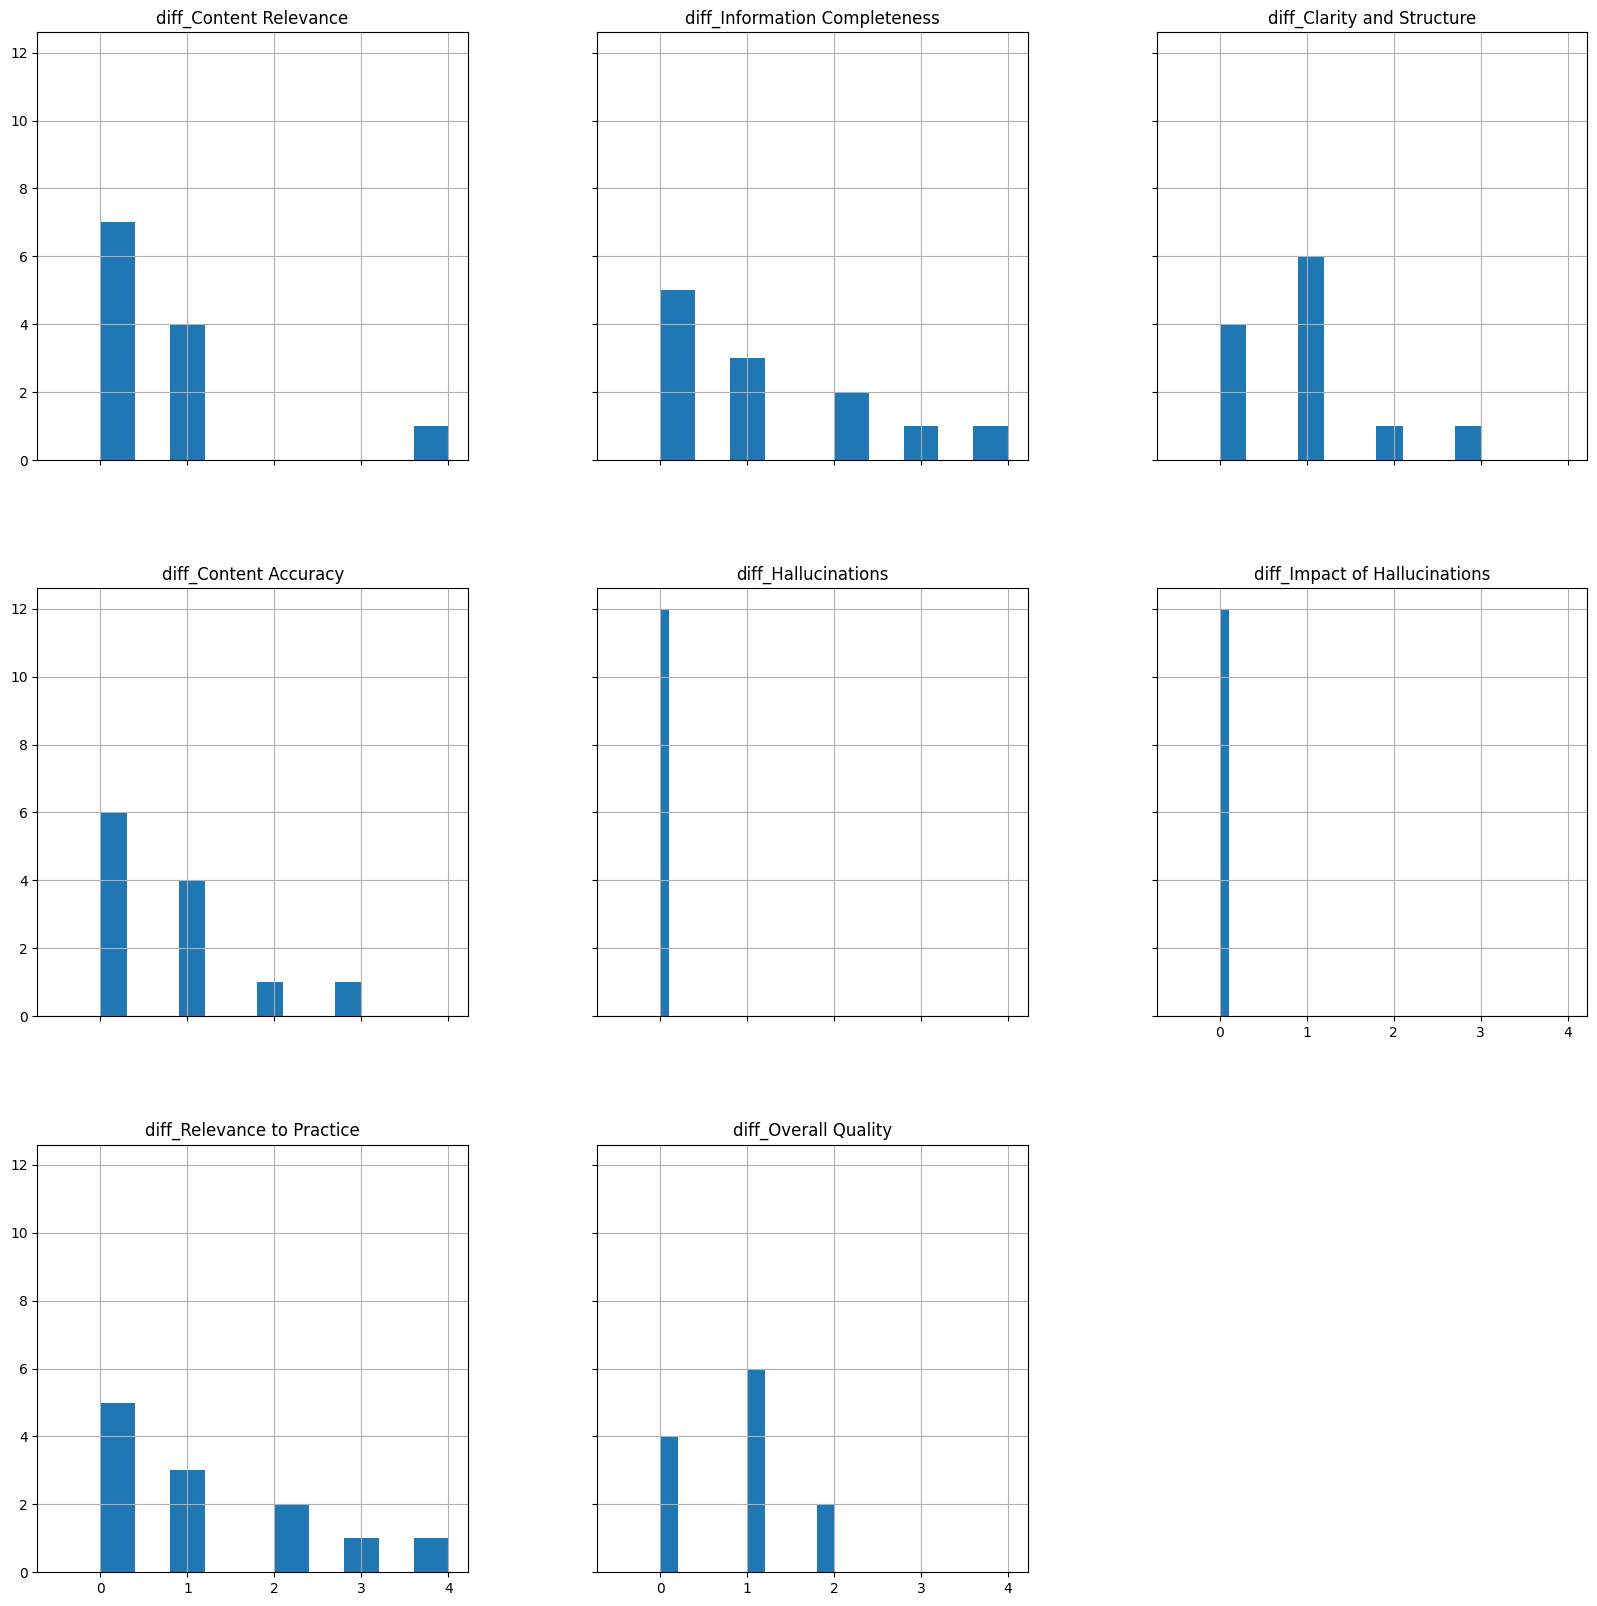

In [30]:
df_human_eval_num = df_human_eval.select_dtypes(np.number)

for col in df_human_eval_num.columns:
    df_total["diff_" + col] = df_total[col + "_model"] - df_total[col + "_human"]
    
df_total[[x for x in df_total.columns if "diff" in x]].hist(figsize=(20, 20), sharex=True, sharey=True)

In [32]:
df_total[df_total["diff_Overall Quality"] == 2].to_dict()

{'filenameid': {10: '30785587', 11: '30930460'},
 'text_orig': {10: 'A 51-year-old male, hypertensive patient, a former smoker, was transferred for treatment of thoracic aortic dissection and heart failure.\n\nAfter a three-week period with progressively more intense chest pain, accompanied by dyspnea, sweating and vomiting, he was admitted to the Hospital in the city where he lived.\n\nAt hospital admission, he had high blood pressure and the diagnosis of thoracic aortic dissection was made. He received antihypertensive and beta-blocker medications. On the fifth day, he was transferred to Instituto do Coração for treatment. At that moment, he was asymptomatic.\n\nThe physical examination (June 14, 2012) showed good general health status, paleness, ++ / 4+, increased jugular venous pressure, heart rate of 80 bpm, blood pressure 80 x 60 mmHg; clear lungs; cardiac auscultation disclosed rhythmic heart sounds and ++++ diastolic murmur on the left sternal border, no abdominal alterations, 

In [28]:
df_total[df_total["Overall Quality_model"] - df_total["Overall Quality_human"] > 2]["Negative highlights of generation process_model"].values[0]

'Lack of information related with clinical course and outcome. Patient evoluciton is not completly well explained. These parts are important in this case.'

In [29]:
df_total[df_total["Overall Quality_model"] - df_total["Overall Quality_human"] > 2]["Negative highlights of generation process_human"].values[0]

'Too much information omitted and the text is overly summarized'

In [ ]:
print(df_total[df_total["Overall Quality_model"] - df_total["Overall Quality_human"] > 2]["text_orig"].values[0])

A 51-year-old male, hypertensive patient, a former smoker, was transferred for treatment of thoracic aortic dissection and heart failure.

After a three-week period with progressively more intense chest pain, accompanied by dyspnea, sweating and vomiting, he was admitted to the Hospital in the city where he lived.

At hospital admission, he had high blood pressure and the diagnosis of thoracic aortic dissection was made. He received antihypertensive and beta-blocker medications. On the fifth day, he was transferred to Instituto do Coração for treatment. At that moment, he was asymptomatic.

The physical examination (June 14, 2012) showed good general health status, paleness, ++ / 4+, increased jugular venous pressure, heart rate of 80 bpm, blood pressure 80 x 60 mmHg; clear lungs; cardiac auscultation disclosed rhythmic heart sounds and ++++ diastolic murmur on the left sternal border, no abdominal alterations, lower limbs without edema, besides palpable and symmetrical pulses.

Labora

In [ ]:
df_total.select_dtypes(np.number).to_csv("tmp.csv")